In [1]:
# Cell 1: ライブラリのインポートとモデル定義
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split

import numpy as np
import warnings
import time
import tqdm
import matplotlib.pyplot as plt

# PyTorchの警告を無視 (開発時は非推奨ですが、Notebookでの実行をスムーズにするため)
warnings.filterwarnings("ignore")

import sys
sys.path.append("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/training/models")
from Binary_classification import Binary_classification as model

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cuda


In [2]:
temp_model = model(latent=100, input_depth=30, input_height=100, input_width=100) 
dummy_input = torch.randn(1, 1, 30, 100, 100) 

# 特徴抽出層まで実行
output_features = temp_model.features(dummy_input)

# 結果のサイズを確認
print(output_features.size())

torch.Size([1, 16, 1, 10, 10])


In [3]:
class DataSet:
    def __init__(self, data, label):
        self.label = label
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [4]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, path, patience=10, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            # self.flog.write(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    
    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
            # self.flog.write(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [5]:
bubble_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/slide_bubble.npy")
removal_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/all_data_after_bubble_removal.npy")

# バブルのラベルは1、非バブルのラベルは0
bubble_label = [1] * len(bubble_data)
removal_label = [0] * len(removal_data)

In [6]:
# print(len(bubble_data))
# print(len(removal_data))
# print(bubble_label)
# print(removal_label)

In [7]:
data = np.concatenate((bubble_data, removal_data))
label = np.concatenate((bubble_label, removal_label))

In [8]:
len(data)

5659

In [9]:
# data = torch.from_numpy(data).float()
train_data, val_data, train_labels, val_labels = train_test_split(
    data, label, test_size=0.2, random_state=42, stratify=label
)
val_data, test_data, val_labels, test_labels = train_test_split(
    val_data, val_labels, test_size=0.25, random_state=42, stratify=val_labels
)

# train_data = augment_data(train_data, augment_horizontal, augment_vertical, augment_velocity_axis)
# train_labels     = [0] * len(train_data)

train_dataset    = DataSet(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset      = DataSet(val_data, val_labels)
val_dataloader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
dataloader_dic   = {"train": train_dataloader, "val": val_dataloader}


# train_dataset = DataSet(train_data, train_labels)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_dataset = DataSet(val_data, val_labels)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# dataloader_dic = {"train": train_dataloader, "val": val_dataloader}

In [10]:
print(849//16)
print(849%16)

53
1


In [11]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

4527
849
283


In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [13]:
model = model(latent=100, input_depth=30, input_height=100, input_width=100)
model.apply(weights_init)
model.to(device)

Binary_classification(
  (features): Sequential(
    (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (8): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (11): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1600, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (

In [14]:
optimizer = optim.AdamW(
        model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False
    )
criterion = nn.BCELoss()

In [15]:
early_stopping = EarlyStopping(patience=50, verbose=True, path="/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/training/save_dir/model_parameter.pth")

In [25]:
train_loss_list = []

val_loss_list = []
val_accuracy_list = []
val_recall_list = []

best_val_loss = float('inf')
start = time.time()
num_epochs = 1000


for epoch in range(num_epochs):
    train_loss_num = 0
    val_loss_num = 0

    # 精度計算のためのカウンター
    val_correct_preds = 0
    val_total_samples = 0

    val_true_positives = 0
    val_actual_positives = 0 # (TP + FN)

    for phase in ["train", "val"]:
        dataloader = dataloader_dic[phase]
        if phase == "train":
            model.train()  # モデルを訓練モードに
        else:
            model.eval()

        for images, labels in tqdm.tqdm(dataloader):
            images = images.view(-1, 1, 30, 100, 100)
            labels = labels.to(device).float().unsqueeze(1)
            print(labels)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):

                # モデルの出力を計算する
                output = model(images.clone().float().to(device))
                # print(output)
                # print(labels)
                # 損失を計算する
                loss = criterion(output.to("cpu"), labels.to("cpu"))
                weighted_loss = torch.mean(loss)

                if phase == "val":
                    # Sigmoid出力 (output) を使用し、0.5を閾値として予測
                    # outputは [B, 1]、labels_deviceは [B, 1]
                    predicted = (output > 0.5).float()
                    
                    # 1. 精度 (Accuracy) の計算
                    val_correct_preds += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)
                    
                    # 2. Recallの計算
                    # a. True Positives (TP): predicted=1 かつ actual=1
                    val_true_positives += ((predicted == 1) & (labels == 1)).sum().item()
                    
                    # b. Actual Positives (TP + FN): actual=1 (正解ラベルが1の総数)
                    val_actual_positives += (labels == 1).sum().item()
                
                # パラメータの更新
                if phase == "train":
                    weighted_loss.backward()
                    optimizer.step()
                    train_loss_num += weighted_loss.item()
                else:
                    val_loss_num += weighted_loss.item()
                    
        # エポック終了後の検証精度の計算
        val_accuracy = val_correct_preds / val_total_samples if val_total_samples > 0 else 0.0
        
        # ⭐ 検証再現率 (Recall) の計算 ⭐
        val_recall = val_true_positives / val_actual_positives if val_actual_positives > 0 else 0.0
        
        if phase == "train":
            train_loss_list.append(train_loss_num)
        else:
            val_loss_list.append(val_loss_num)
            val_accuracy_list.append(val_accuracy)
            val_recall_list.append(val_recall)
            
    # wandb.log({"train loss": train_loss_num, "validation loss": val_loss_num, "epoch":  epoch})
    # if val_loss_num < best_val_loss:
    #     best_val_loss = val_loss_num
        # wandb.log({"best validation loss": best_val_loss, "epoch":  epoch})
    
    # print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, val_loss_num))
    print("Epoch [{}/{}], Val Loss: {:.4f}, Val Accuracy: {:.4f}, Val Recall: {:.4f}".format(
        epoch + 1, num_epochs, val_loss_num, val_accuracy, val_recall # Recallを追加
    ))
    print("")
    
    early_stopping(val_loss_num, model)
    if early_stopping.early_stop:
        print("Early_Stopping")
        break

#train_loss_path = args.savedir_path + "/loss_log" + f"/train_loss_{args.wandb_name}.npy"
#val_loss_path = args.savedir_path + "/loss_log" + f"/val_loss_{args.wandb_name}.npy"

#np.save(train_loss_path, train_loss_list)
#np.save(val_loss_path, val_loss_list)

print((time.time() - start) / 60)

  5%|███▉                                                                                   | 13/283 [00:00<00:04, 63.17it/s]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.]], device='cuda:0')
tensor([[6.3984e-09],
        [1.8360e-09],
        [1.0248e-07],
        [9.0382e-09],
        [3.5229e-12],
        [3.3563e-11],
        [2.0128e-14],
        [2.0219e-08],
        [2.0271e-07],
        [1.6218e-08],
        [1.2668e-09],
        [5.2962e-10],
        [9.0517e-08],
        [9.9997e-01],
        [2.1173e-08],
        [2.9796e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[4.9034e-07],
        [2.3435e-11],
        [5.9192e-08],
        [9.6628e-07],
        [7.8599e-05],
        

  7%|██████▍                                                                                | 21/283 [00:00<00:03, 68.06it/s]

tensor([[8.1921e-06],
        [8.3704e-11],
        [9.6292e-06],
        [6.2087e-06],
        [1.6574e-07],
        [1.0343e-07],
        [1.5679e-04],
        [1.4760e-12],
        [4.2280e-16],
        [9.9878e-01],
        [2.7388e-06],
        [1.0131e-05],
        [2.6730e-08],
        [4.8157e-10],
        [3.7311e-09],
        [2.0610e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[2.4321e-06],
        [1.0000e+00],
        [1.6069e-04],
        [3.0378e-05],
        [9.0263e-09],
        [2.4277e-07],
        [8.7008e-10],
        [3.4392e-07],
        [8.2812e-09],
        [1.3149e-06],
        [8.5570e-10],
        [5.6934e-09],
        [4.4338e-04],
        [3.7983e-11],
        [5.4182e-08],
        [3.3975e-08]], device=

 13%|███████████                                                                            | 36/283 [00:00<00:03, 68.89it/s]

tensor([[2.9878e-06],
        [1.9259e-06],
        [1.6799e-08],
        [1.2940e-11],
        [4.0334e-08],
        [9.1530e-10],
        [2.0343e-12],
        [1.2599e-09],
        [1.2185e-07],
        [5.3359e-11],
        [9.9999e-01],
        [5.0261e-10],
        [1.0817e-08],
        [1.0797e-06],
        [5.3648e-08],
        [2.0486e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[2.5779e-13],
        [1.3076e-05],
        [4.5055e-09],
        [9.8101e-10],
        [1.1497e-06],
        [5.7598e-04],
        [3.2980e-08],
        [2.9899e-06],
        [1.1007e-05],
        [1.0637e-06],
        [7.2132e-09],
        [9.9861e-09],
        [2.3155e-08],
        [2.5773e-09],
        [1.1486e-09],
        [2.7191e-08]], device=

 18%|███████████████▉                                                                       | 52/283 [00:00<00:03, 70.97it/s]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[3.1835e-09],
        [8.7048e-09],
        [1.8648e-10],
        [5.5816e-07],
        [7.1973e-08],
        [1.6842e-04],
        [6.2208e-09],
        [6.0352e-05],
        [2.8390e-09],
        [7.9174e-08],
        [8.5697e-09],
        [4.2523e-05],
        [3.8456e-09],
        [3.7203e-08],
        [9.3238e-13],
        [9.0936e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')
tensor([[3.0373e-10],
        [2.5509e-07],
        [8.2687e-13],
        [1.4042e-08],
        [3.5304e-08],
        

 24%|████████████████████▉                                                                  | 68/283 [00:00<00:03, 70.02it/s]

tensor([[2.5270e-11],
        [2.5943e-10],
        [7.5164e-06],
        [1.5965e-03],
        [1.2357e-08],
        [1.6420e-06],
        [1.3397e-09],
        [3.7027e-07],
        [2.9203e-08],
        [8.1784e-05],
        [9.6573e-08],
        [4.3898e-10],
        [9.7926e-08],
        [1.5800e-05],
        [8.3988e-10],
        [2.7770e-10]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[3.5792e-07],
        [1.1136e-10],
        [2.9904e-10],
        [9.8859e-05],
        [7.6801e-04],
        [3.2572e-07],
        [1.0000e+00],
        [3.6592e-09],
        [7.3381e-11],
        [2.1603e-07],
        [1.3638e-09],
        [2.2168e-11],
        [1.9168e-07],
        [5.8847e-06],
        [7.6592e-10],
        [3.2651e-08]], device=

 30%|█████████████████████████▊                                                             | 84/283 [00:01<00:02, 69.89it/s]

tensor([[3.1092e-06],
        [5.2058e-06],
        [1.8140e-05],
        [2.0633e-08],
        [4.5000e-06],
        [1.3155e-07],
        [5.4717e-08],
        [1.8706e-09],
        [2.1709e-07],
        [4.9958e-09],
        [9.8089e-07],
        [2.3925e-05],
        [1.1242e-09],
        [1.0597e-07],
        [1.1251e-03],
        [3.6804e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[4.3303e-07],
        [1.6909e-09],
        [1.1587e-09],
        [1.0000e+00],
        [4.4063e-05],
        [4.3036e-06],
        [4.5541e-12],
        [7.0482e-09],
        [3.0565e-07],
        [2.3951e-08],
        [2.5156e-04],
        [2.6746e-07],
        [1.6272e-12],
        [2.1600e-08],
        [1.1141e-07],
        [3.9499e-08]], device=

 35%|██████████████████████████████▍                                                       | 100/283 [00:01<00:02, 71.17it/s]

tensor([[8.8635e-08],
        [4.7393e-09],
        [1.7398e-05],
        [6.4184e-08],
        [2.3533e-06],
        [2.1718e-10],
        [2.1942e-07],
        [1.0837e-08],
        [1.0474e-04],
        [6.3193e-07],
        [9.9999e-01],
        [7.0947e-13],
        [4.6596e-08],
        [7.3346e-10],
        [2.5226e-08],
        [1.6100e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[2.5891e-10],
        [5.0815e-06],
        [1.3671e-08],
        [4.2575e-08],
        [1.5692e-06],
        [1.2755e-09],
        [9.1398e-06],
        [2.8744e-05],
        [9.7166e-12],
        [1.4033e-08],
        [1.3227e-09],
        [6.9003e-11],
        [8.1217e-10],
        [1.2469e-07],
        [1.5726e-06],
        [3.3398e-06]], device=

 38%|████████████████████████████████▊                                                     | 108/283 [00:01<00:02, 71.76it/s]

tensor([[3.6713e-07],
        [7.0918e-10],
        [5.5069e-08],
        [1.3130e-09],
        [4.3054e-15],
        [9.9927e-01],
        [5.7689e-10],
        [2.9564e-07],
        [4.2742e-08],
        [1.9827e-05],
        [5.3303e-08],
        [4.6351e-07],
        [1.9589e-05],
        [9.9666e-06],
        [8.0844e-06],
        [2.7255e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[8.2398e-10],
        [2.2683e-09],
        [5.3560e-06],
        [4.8297e-09],
        [9.0484e-05],
        [1.0557e-03],
        [2.6494e-08],
        [1.3916e-06],
        [3.7936e-07],
        [1.0063e-12],
        [8.8139e-06],
        [6.6431e-10],
        [1.9605e-12],
        [1.7133e-14],
        [1.3188e-08],
        [2.2720e-06]], device=

 44%|█████████████████████████████████████▋                                                | 124/283 [00:01<00:02, 72.80it/s]

tensor([[3.1798e-08],
        [1.0896e-09],
        [1.4101e-11],
        [2.0780e-08],
        [1.4013e-10],
        [3.1748e-04],
        [1.3080e-07],
        [4.9516e-04],
        [1.2725e-06],
        [8.4515e-10],
        [7.2916e-06],
        [8.1156e-07],
        [3.3298e-06],
        [1.6973e-11],
        [7.9072e-06],
        [6.4016e-06]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[2.2269e-06],
        [1.5219e-14],
        [3.8209e-08],
        [1.2178e-08],
        [2.4262e-08],
        [3.8068e-07],
        [7.8565e-05],
        [1.4787e-09],
        [7.5084e-09],
        [1.0000e+00],
        [8.0580e-09],
        [3.1942e-07],
        [1.7595e-09],
        [5.0832e-05],
        [1.2253e-06],
        [2.6456e-09]], device=

 49%|██████████████████████████████████████████▌                                           | 140/283 [00:01<00:01, 73.21it/s]

tensor([[4.8058e-10],
        [3.3516e-11],
        [9.8744e-01],
        [1.0420e-05],
        [3.6289e-09],
        [5.3322e-10],
        [9.6455e-09],
        [6.0820e-07],
        [4.6931e-12],
        [4.7686e-07],
        [3.2194e-05],
        [1.4281e-06],
        [7.1358e-06],
        [3.1294e-07],
        [1.3529e-06],
        [4.5222e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[8.4389e-04],
        [6.1111e-08],
        [8.6915e-07],
        [1.7612e-05],
        [2.4655e-13],
        [2.4008e-08],
        [7.1024e-10],
        [4.1093e-08],
        [1.5915e-06],
        [3.0356e-08],
        [6.2633e-09],
        [1.1867e-05],
        [2.8213e-10],
        [6.5580e-12],
        [1.1801e-07],
        [3.1613e-10]], device=

 55%|███████████████████████████████████████████████▍                                      | 156/283 [00:02<00:01, 72.99it/s]

tensor([[5.8020e-08],
        [2.8296e-07],
        [1.7810e-10],
        [5.7722e-08],
        [4.6438e-08],
        [1.0429e-06],
        [9.7113e-10],
        [1.4437e-09],
        [1.0743e-04],
        [4.8679e-08],
        [3.1287e-05],
        [1.3613e-06],
        [2.2279e-08],
        [2.6298e-04],
        [1.1164e-06],
        [4.7715e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[3.7946e-08],
        [9.5401e-08],
        [1.2725e-04],
        [6.1549e-04],
        [1.4054e-05],
        [3.9451e-05],
        [5.0412e-08],
        [6.4344e-10],
        [1.7234e-07],
        [2.2531e-10],
        [1.0000e+00],
        [2.3975e-08],
        [8.7094e-07],
        [1.4925e-07],
        [1.2306e-06],
        [7.0678e-06]], device=

 61%|████████████████████████████████████████████████████▎                                 | 172/283 [00:02<00:01, 72.52it/s]

tensor([[4.3492e-11],
        [2.5574e-09],
        [8.0887e-06],
        [1.7892e-08],
        [2.0258e-05],
        [4.4194e-05],
        [1.0014e-07],
        [1.0535e-06],
        [1.7467e-09],
        [1.6354e-06],
        [3.8868e-06],
        [1.1254e-04],
        [4.9751e-08],
        [1.6038e-04],
        [6.5112e-08],
        [1.4282e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[1.0671e-13],
        [1.6979e-05],
        [1.0000e+00],
        [1.5675e-11],
        [2.7569e-08],
        [3.7817e-07],
        [1.7262e-10],
        [9.9979e-01],
        [1.4282e-07],
        [7.3600e-07],
        [3.6143e-07],
        [9.9724e-01],
        [1.5722e-07],
        [2.5010e-13],
        [3.3881e-08],
        [1.8370e-10]], device=

 66%|█████████████████████████████████████████████████████████▏                            | 188/283 [00:02<00:01, 72.05it/s]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[3.2116e-08],
        [1.6405e-06],
        [2.9097e-08],
        [2.5085e-05],
        [3.0059e-06],
        [1.3706e-09],
        [1.8599e-07],
        [5.5195e-07],
        [7.1980e-06],
        [1.5031e-05],
        [4.6666e-10],
        [8.0305e-09],
        [6.9428e-06],
        [2.5577e-09],
        [1.0319e-04],
        [1.8619e-09]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[1.4385e-09],
        [5.6607e-10],
        [2.2483e-12],
        [2.9949e-05],
        [1.8673e-06],
        

 72%|█████████████████████████████████████████████████████████████▉                        | 204/283 [00:02<00:01, 72.21it/s]

tensor([[7.8720e-07],
        [9.8772e-09],
        [5.5035e-08],
        [9.9996e-01],
        [2.9501e-06],
        [1.0905e-04],
        [2.5745e-07],
        [4.4504e-11],
        [1.9129e-07],
        [2.2588e-09],
        [1.3547e-07],
        [5.8378e-10],
        [2.6315e-07],
        [1.0000e+00],
        [2.7763e-07],
        [1.9864e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[7.3588e-12],
        [2.2546e-11],
        [3.1606e-07],
        [6.1856e-08],
        [4.3564e-05],
        [1.2681e-05],
        [5.6369e-05],
        [1.4836e-08],
        [6.3329e-11],
        [3.2270e-06],
        [2.5483e-10],
        [6.3142e-05],
        [1.3629e-06],
        [2.7326e-07],
        [3.2800e-09],
        [6.1725e-05]], device=

 75%|████████████████████████████████████████████████████████████████▍                     | 212/283 [00:02<00:00, 72.20it/s]

tensor([[8.6567e-06],
        [1.1394e-08],
        [9.9770e-07],
        [2.4935e-03],
        [7.8617e-05],
        [2.8197e-09],
        [2.7007e-08],
        [5.1577e-10],
        [7.2640e-07],
        [3.0260e-07],
        [2.3226e-07],
        [1.0799e-10],
        [5.1161e-06],
        [2.5862e-06],
        [4.9188e-08],
        [1.2709e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]], device='cuda:0')
tensor([[1.6538e-08],
        [6.9650e-07],
        [5.6377e-08],
        [3.1287e-10],
        [9.9998e-01],
        [6.2361e-08],
        [2.4769e-08],
        [7.7564e-07],
        [1.4747e-05],
        [2.9891e-06],
        [1.3136e-09],
        [2.0788e-06],
        [1.0000e+00],
        [1.4983e-10],
        [1.0000e+00],
        [1.4023e-11]], device=

 81%|█████████████████████████████████████████████████████████████████████▎                | 228/283 [00:03<00:00, 71.88it/s]

tensor([[1.0701e-09],
        [9.6572e-09],
        [9.9915e-01],
        [1.0000e+00],
        [1.6817e-06],
        [1.4895e-09],
        [1.5041e-08],
        [1.9207e-04],
        [9.4092e-08],
        [4.9464e-13],
        [8.1517e-12],
        [2.9307e-05],
        [5.1932e-11],
        [5.7643e-13],
        [3.6276e-07],
        [1.1293e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[1.5937e-10],
        [4.0578e-08],
        [3.6468e-07],
        [6.3106e-07],
        [8.9003e-08],
        [4.7374e-05],
        [4.9805e-05],
        [1.6164e-15],
        [2.3673e-08],
        [1.1943e-04],
        [3.4950e-09],
        [9.3207e-08],
        [1.8849e-06],
        [7.0276e-11],
        [1.0322e-03],
        [1.2107e-05]], device=

 84%|████████████████████████████████████████████████████████████████████████              | 237/283 [00:03<00:00, 71.02it/s]


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[6.5729e-12],
        [1.1229e-07],
        [3.2970e-08],
        [1.1891e-11],
        [2.1188e-09],
        [2.1804e-06],
        [1.9583e-08],
        [5.2959e-08],
        [8.7912e-06],
        [8.0502e-08],
        [8.0241e-08],
        [5.1815e-05],
        [7.9536e-08],
        [4.9359e-08],
        [5.7679e-07],
        [3.1440e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
tensor([[7.9908e-09],
        [4.9061e-11],
        [1.1709e-08],
        [3.8666e-06],
        [2.0579e-07],
        

KeyboardInterrupt: 

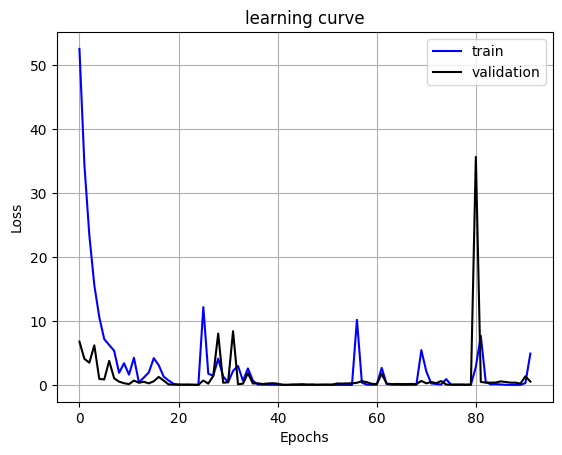

In [21]:
plt.plot(range(len(train_loss_list)), train_loss_list, "b", label="train")
plt.plot(range(len(val_loss_list)), val_loss_list, "k", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("learning curve")
plt.legend()
plt.grid()
plt.savefig("Add_MaxPlool.png")
plt.show()

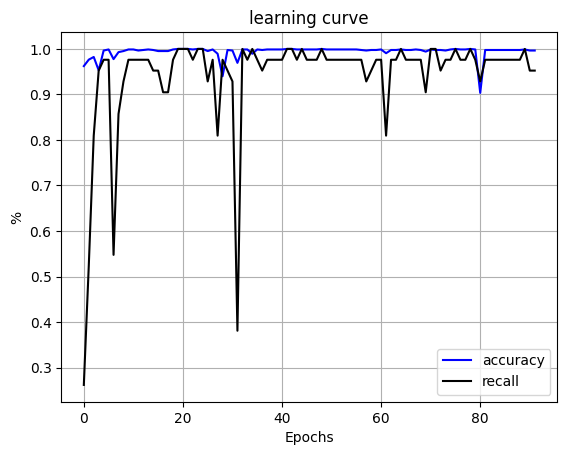

In [22]:
plt.plot(range(len(val_accuracy_list)), val_accuracy_list, "b", label="accuracy")
plt.plot(range(len(val_recall_list)), val_recall_list, "k", label="recall")
plt.xlabel("Epochs")
plt.ylabel("%")
plt.title("learning curve")
plt.legend()
plt.grid()
plt.savefig("Add_MaxPool_acurracy.png")
plt.show()

In [19]:
import math
print(math.log(0.98))

-0.020202707317519466
